# ML LabExercise --- Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.datasets import load_iris
import os, wget, sys

def sr_download(file):
    if not os.path.isfile(file):
        url = "https://staff.fnwi.uva.nl/r.vandenboomgaard/downloads/" + file
        print('[sr]',f'Downloading file {file} for statistical reasoning course')
        wget.download(url)
    else:
        print('[sr]',f'data {file} already downloaded')




## Linear Regression

### Introduction

In this LabExercise you have to program linear regression using a gradient descent procedure. We start with a simple straight line univariate regression. And then we generalize to multivariate linear regression and try to predict house prizes.

In this cell some hidden $\LaTeX$ definition.
$\renewcommand{\t}{\theta}$
$\renewcommand{\v}[1]{{\boldsymbol #1}}$
$\renewcommand{\hv}[1]{\widetilde{\v #1}}$
$\renewcommand{\T}{^\top}$
$\renewcommand{\inv}{^{-1}}$
$\renewcommand{\ls}[1]{{^{(#1)}}}$

### Univariate Toy Problem To Get Started

#### Fitting a First Order Model

We will be looking at the classical problem of fitting a straight line through a lot of points. The resulting least squares solution has a closed form analytical solution. But in this lab we will focus on the machine learning perspective on this **regression problem** and solve the problem using an **iterative gradient descent** technique.

First we generate test data. Because we generate the data, the 'true' value is known
$$y_{\text{true}} = 100 x + 30$$
where $x$ takes values in the interval from $0$ to $10$.
The observed values are
$$y = y_\text{true}  + y_\text{noise}$$
where $y_\text{noise}$ is noise. For every observation the noise value will be different but comes from normal distributions that are independent and identically distributed.

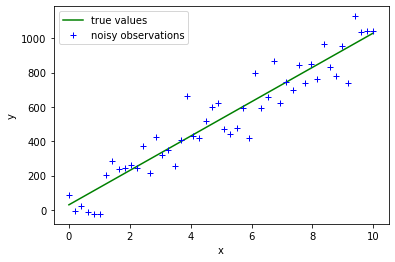

In [2]:
rng = np.random.default_rng(seed=66)
x_1st = np.linspace(0,10,50)
yt = 100 * x_1st + 30
y_1st = yt + 100 * rng.standard_normal(*yt.shape)
plt.plot(x_1st, yt, '-g', label='true values')
plt.plot(x_1st, y_1st, '+b', label='noisy observations')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

The goal of linear regression is to find the functional relation between the $x$ and $y$ values given the noise data points. We start with a simple 1st order model for this relation, which we in this case know to be the true functional relation. In practical applications the model is only an assumption about the mathematical relation between the $x$ and $y$ values.

#### Analytical Solution

The 1st order model for our data is
$$h_{\v\t}(x) = \t_0 + \t_1 x$$
Evidently given the way the data is generated we hope to estimate $\v\t=(\t_0\;\t_1)^T = (30\;100)^T$ from the noisy data.

First we make the augmented data matrix 
$$\hv X = \begin{pmatrix}1 & x\ls 1\\ 1& x\ls 2\\\vdots & \vdots\\1& x\ls m\end{pmatrix}$$ by concatenating a column of 1's with the vector of all data points.

In [3]:
tX_1st = np.vstack((np.ones_like(x_1st),x_1st)).T
print(tX_1st[:5])

[[1.         0.        ]
 [1.         0.20408163]
 [1.         0.40816327]
 [1.         0.6122449 ]
 [1.         0.81632653]]


The analytical solution is given as:
$$\hat{\v\t} = \left(\hv X\T \hv X\right)\inv \hv X\T \v y$$ 

In [4]:
theta_1st = np.linalg.inv(tX_1st.T @ tX_1st) @ tX_1st.T @ y_1st
print(theta_1st)

[ 23.57141835 100.15038091]


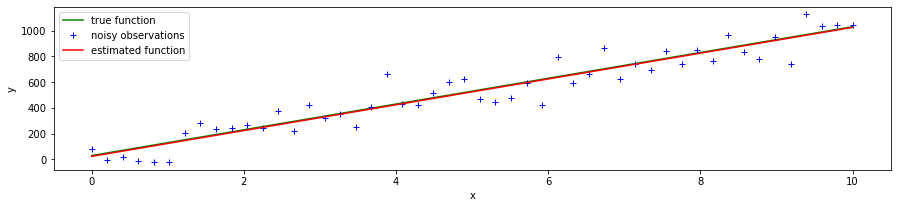

In [5]:
plt.figure(figsize=(15,3))
plt.plot(x_1st, yt, '-g', label='true function')
plt.plot(x_1st, y_1st, '+b', label='noisy observations')
plt.plot(x_1st, tX_1st @ theta_1st, '-r', label='estimated function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');

The analytical solution is not too bad when comparing the plot of the known truth and the estimating model from the noisy data. Below you should calculate the cost of the analytical solution. The correct formula can be found in the lecture notes to be:
$$J(\hv\t) = \frac{1}{2 m} \|\hv X\v\t - \v y\|^2$$
where $m$ is the number of examples used for estimation the parameter vector.

In [28]:
def calculate_cost(X, y, theta):
    m = len(y)
    return 1/(2*m) * np.sum((X @ theta - y)**2)

In [29]:
print(f"the cost is: {calculate_cost(tX_1st, y_1st, theta_1st):5.1f}")

the cost is: 4645.8


#### Gradient Descent Solution

In machine learning we will often minimize a cost function to obtain the optimal parameters for the learning system. It is however seldom that a closed form analytical solution, like we have used in the previous section, can be found. In such cases we have to resort to a numerical technique to find those optimal parameter values.

Read the [lecture notes](https://staff.fnwi.uva.nl/r.vandenboomgaard/MachineLearning/LectureNotes/Regression/LinearRegression/univariate_linear_regression.html#univariate-linear-regression) for a detailed explanation, in this LabExercise we only state the main results.

The cost function associated with first order univariate linear regression is stated as
$$J(\v\t) = \frac{1}{2m} \sum_{i=1}^{m} \left( h_{\v\t}(x\ls i) - y\ls i \right)^2$$
where our parameterized model is
$$h_{\v\t}(x) = \t_0 + \t_1 x$$

Starting with some arbitrary guess for $\v\t$ the value of $\v\t$ is then iteratively updated by subtracting $\alpha$ times the gradient vector:
$$\v\theta := \v\theta -
\alpha \frac{\partial J(\v\theta)}{\partial \v\theta}$$
This gradient descent procedure is repeated until convergence (or most often in practice for a fixed number of iterations while keeping track of the cost function in the process).

Collecting all learning examples in the augmented data matrix $\hv X$ and target vector $\v y$ we have seen that
$$J(\v\t) = \frac{1}{2m}\|\hv X\v\t-\v y\|^2$$
The gradient is then given as
$$\frac{\partial J(\v\theta)}{\partial \v\theta} = \frac{1}{m} \hv X\T (\hv X \v\theta - \v y)$$

Please complete the following functions in order to calculate the optimal $\v \theta$ vector

In [58]:
def calculate_gradient(X, y, theta):
    # calculate the gradient and return its value 
    # (in array of shape theta.shape)
    # X: augmented data matrix
    # y: target vector
    # theta: parameter vector

    m = len(y)
    grad = 1/m * X.T @ (X @ theta - y)
    return grad


def gradient_descent(start_theta, alpha, n_iter, X, y, verbose=False, iter_fraction=10):
    # update the theta vector n_iter times starting 
    # with theta = start_theta using learning speed alpha
    # start_theta: starting value of parameter vector theta
    # alpha: learning speed
    # n_iter: no of iterations to be done
    # X: augmented data matrix
    # y: target vector
    # verbose: True then print intermediate results
    # iter_fraction: print at each 'n_iter/iter_fraction' iteration
    # the function returns a tuple theta, costs
    # where theta is the parameter vector and costs is an array
    # of shape (n_iter,) that gives the result of `calculate_cost` 
    # after each iteration.
    theta = start_theta
    costs = np.zeros((n_iter))
    for i in range(n_iter):
        # calculate the new value of theta
        theta = theta - alpha * calculate_gradient(X, y, theta)
        # calculate the new cost
        costs[i] = calculate_cost(X, y, theta)
        if verbose:
            if i%(n_iter//iter_fraction) == 0:
                print(f"Iteration {i:5d}, cost {calculate_cost(X, y, theta):10.3f}")
    if verbose:
        print(f"Iteration {i:5d}, cost {calculate_cost(X, y, theta):10.3f}")
    return theta, costs

Iteration     0, cost 184357.577
Iteration   100, cost  94823.890
Iteration   200, cost  49898.727
Iteration   300, cost  27356.695
Iteration   400, cost  16045.802
Iteration   500, cost  10370.335
Iteration   600, cost   7522.545
Iteration   700, cost   6093.593
Iteration   800, cost   5376.569
Iteration   900, cost   5016.768
Iteration   999, cost   4837.468
[14.89744422 98.15045762]


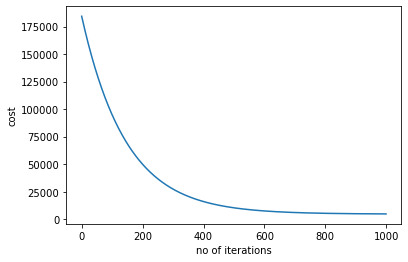

In [59]:
theta_1st_gd, costs = gradient_descent(np.array([0,0]), 0.0001, 1000, tX_1st, y_1st, verbose=True) # this combination of parameters should work
print(theta_1st_gd)
plt.plot(costs)
plt.xlabel('no of iterations')
plt.ylabel('cost');

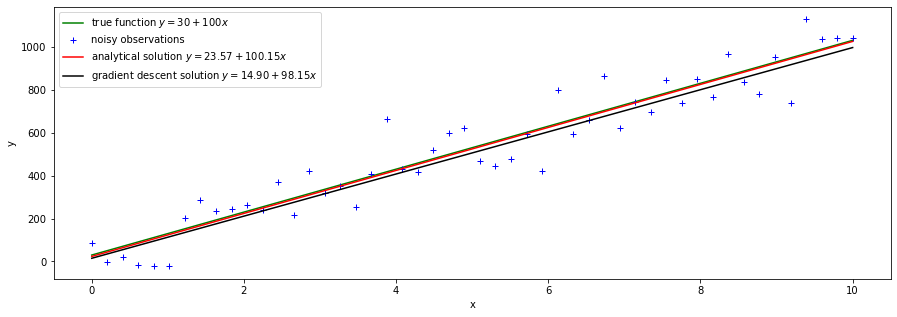

In [60]:
plt.figure(figsize=(15,5))
plt.plot(x_1st, yt, '-g', label=f'true function $y=30+100x$') # the 'true' function
plt.plot(x_1st, y_1st, '+b', label='noisy observations') # the noisy observations
plt.plot(x_1st, tX_1st @ theta_1st, '-r', 
         label=f'analytical solution $y = {theta_1st[0]:5.2f} + {theta_1st[1]:5.2f}x$'); # analytical solution
plt.plot(x_1st, tX_1st @ theta_1st_gd, '-k', 
         label=f'gradient descent solution $y = {theta_1st_gd[0]:5.2f} + {theta_1st_gd[1]:5.2f}x$'); # gradient descent solution
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

### Fitting Higher Order Polynomial Models

Next we look at data where a first order model is too simplistic:

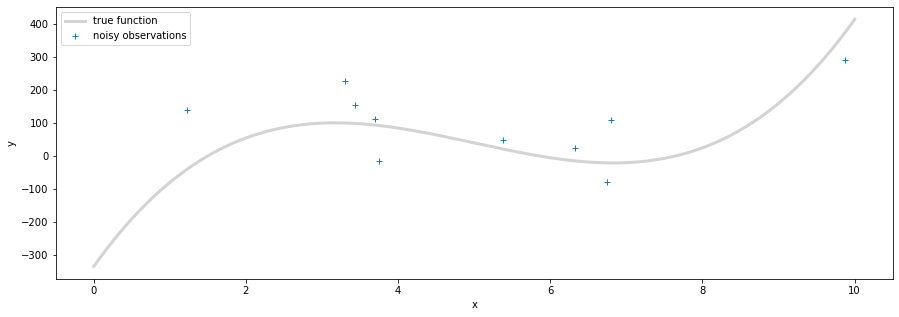

In [61]:
def f_true(x):
    return 10 * (1/2 * (x - 5) ** 3 - 5 * (x - 5) + 4)

plt.figure(figsize=(15,5))
xx_3rd = np.linspace(0, 10, 5000)
yy_3rd = f_true(xx_3rd)
plt.plot(xx_3rd, yy_3rd, lw=3, color='lightgray', label='true function')

rng = np.random.default_rng(seed=6)
x_3rd = rng.uniform(low=0, high=10, size=10)
y_3rd = f_true(x_3rd) + 100 * rng.normal(size=x_3rd.shape)

plt.plot(x_3rd, y_3rd, '+', label='noisy observations')

plt.legend()
plt.xlabel('x')
plt.ylabel('y');


**A note on the seed. In many notebooks the seed for the random number generator is set explicitly (in order to get reproducible results necessary for automated grading). You are however advised to try the code without setting the seed to get an impression of the randomness of the experiments.**

We will consider model functions $h_{\v\t}(x)$ of the form:
$$h_{\v\t}^{(k)}(x) = \sum_{n=0}^k \t_n x^n$$
for $k=0,1,3,5,9$.

Let $x\ls i$ be one of the examples in the learning set then the corresponding row in the augmented data matrix is dependent on the order of the model:
$$k=0:\qquad (1)$$
$$k=1:\qquad (1\;x)$$
$$k=2:\qquad (1\;x\;x^2)$$
etc

Write a function ``make_augmented_univariate_matrix`` that takes the **vector** of scalar learning examples $(x\ls 1\cdots x\ls m)$ and returns the augmented data matrix for order ``k``:

In [63]:
def make_augmented_univariate_matrix(x, order):
    return np.array([x**i for i in range(order+1)]).T

Let's fit a 1st order model (k=1) to the data (using the analytical solution). Here we won't use the theoretical analytical solution with the inverse matrix:
$$\hat{\v\t} = \left(\hv X\T \hv X\right)\inv \hv X\T \v y$$ 
But we will use the scipy.linalg.lstsq function that is optimized for a least squares optimization problem. The numerical stability is much better than using the inverse or even using the sci.linalg.solve function.

[ -52.29486557   58.34239475   15.34573476 -111.47306424  173.03451677
  -82.40446922 -185.78227223  132.14293109    1.12248344   51.96661045]


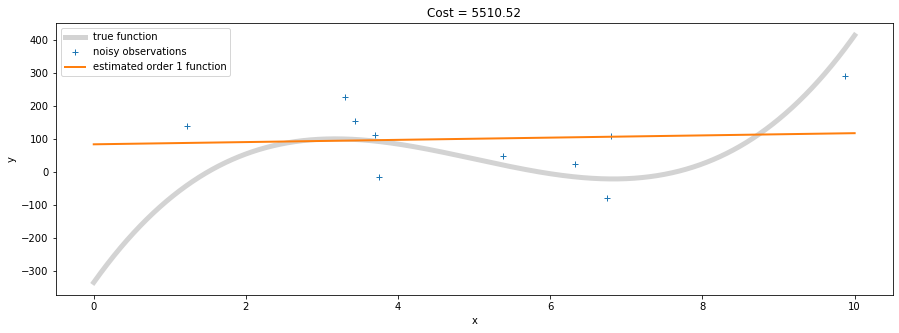

In [64]:
k = 1
tX = make_augmented_univariate_matrix(x_3rd, k) # make augmented data matrix $\tilde X$ (tX)
# theta = scipy.linalg.solve(tX.T @ tX, tX.T @ y_3rd) # analytical solution for theta
theta,_,_,_ = scipy.linalg.lstsq(tX, y_3rd) # we don't need the other return values.
print(y_3rd-tX@theta)
plt.figure(figsize=(15,5))
# plot the high resolution (many increasing x values in xx array) true function (arrays defined in previous cell)
plt.plot(xx_3rd, yy_3rd, lw=5, color='lightgray', label='true function')
# plot the noisy observations
plt.plot(x_3rd, y_3rd, '+', label='noisy observations')

# calculate the estimated y values for all x values in xx
tXX = make_augmented_univariate_matrix(xx_3rd, k)
yy = tXX @ theta
plt.plot(xx_3rd, yy, lw=2, label=f'estimated order {k} function')
plt.legend()
plt.xlabel('x')
plt.ylabel('y');
plt.title(f'Cost = {calculate_cost(tX, y_3rd, theta):5.2f}'); ## assuming your calculate_cost is generic


Make plots like the one above but for $k=0,1,3,5,7,9$. Make the legend readable and informative. For each $k$ also calculate the cost on the learning set and store it in array ``cost_learn`` (of shape ``(len(ks),)``). For each $k$ also store the $\v\t$ vector in a list ``theta_learn``. **We won't test/grade the plots, but we will test/grade the cost on the learning set as function of the order.**

NameError: name 'X' is not defined

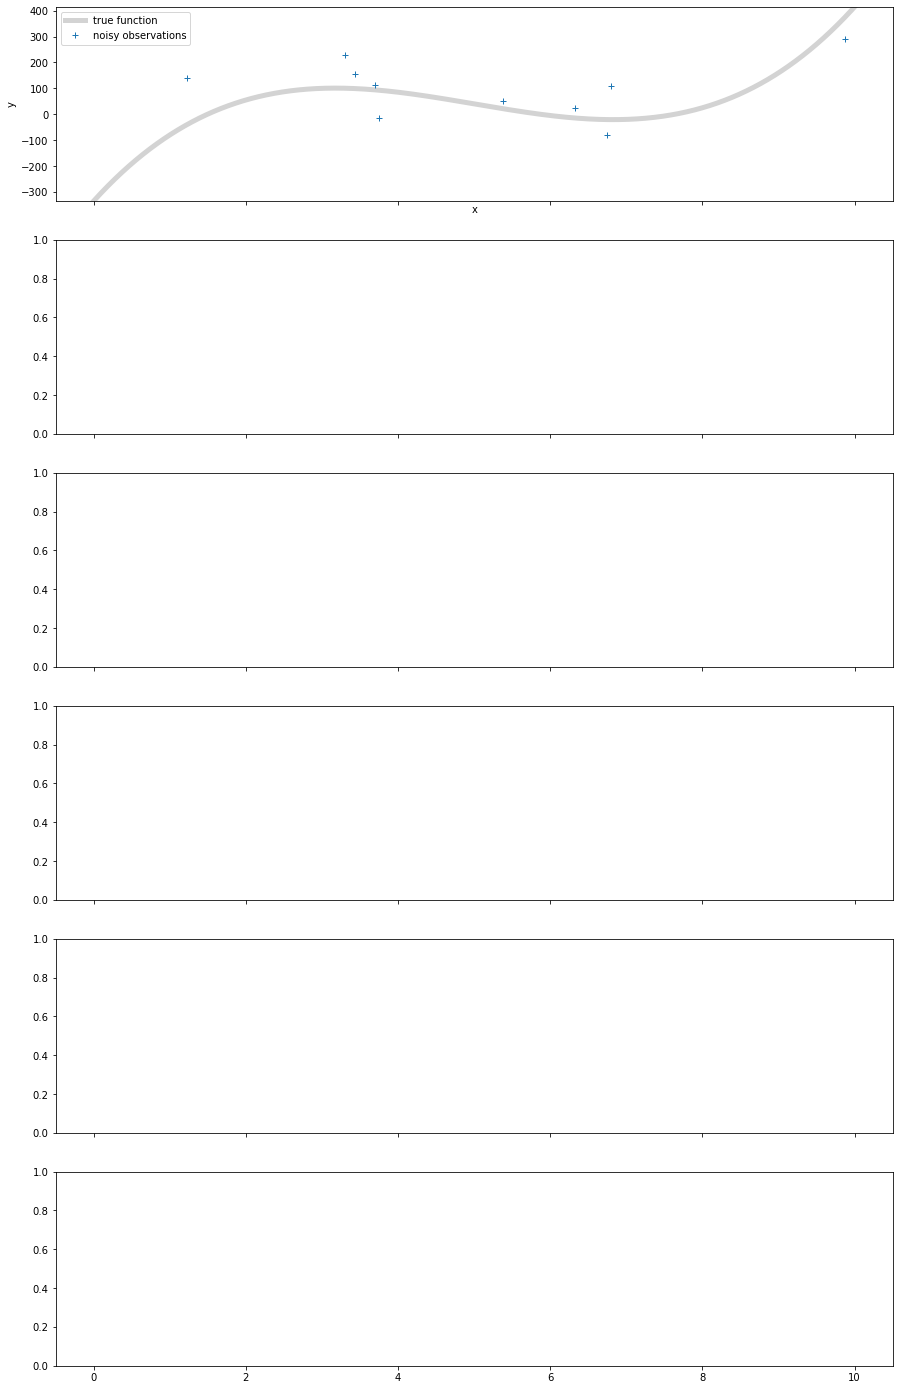

In [65]:
mn = yy_3rd.min()
mx = yy_3rd.max()
ks = [0,1,3,5,7,9]
cost_learn = np.zeros_like(ks)
theta_learn = []
fig, axs = plt.subplots(len(ks), sharex=True, figsize=(15,25));
for i, k in enumerate(ks):
    axs[i].plot(xx_3rd, yy_3rd, lw=5, color='lightgray', label='true function')
    axs[i].plot(x_3rd, y_3rd, '+', label='noisy observations')
    # calculate the estimator for the theta vector
    # and plot the estimated values for each point x in the xx_3rd array
    #. Your solution here ...
    axs[i].legend()
    axs[i].set_xlabel('x')
    axs[i].set_ylabel('y');
    axs[i].set_ylim((mn, mx))
    cost_learn[i] = calculate_cost(X, y_3rd, theta)
    theta_learn.append(theta)
    axs[i].text(8, -200, f'Order {k}, Cost = {cost_learn[i]:5.2f}');

Next we plot and print the cost on the learning set. You should be able to explain (not graded but a typical exam question) why the cost is decreasing even in case the order of our model is higher than the model used to generate the data.

In [ ]:
plt.stem(ks, cost_learn);
for k, c in zip(ks, cost_learn):
    print(k, c)
plt.xlabel('k (order of model)')
plt.ylabel('cost on learning set');

If all went well you should be able to observe that the cost gets lower for increasing order. Even for orders above the 'true order' of 3. You should be able to explain why that is (not graded but a typical exam question).

Now we will test our linear regression using new data (from the same 'true model' but with different noise added). We calculate the cost of fitting the models learned on the original data using the new data. This will give insight in the true performance of the models working on 'unseen' data.

In [ ]:
rng = np.random.default_rng(seed=666)
x_3rd_test = rng.uniform(low=0, high=10, size=200)
y_3rd_test = f_true(x_3rd_test) + 100 * rng.normal(size=x_3rd_test.shape)

mn = yy_3rd.min()
mx = yy_3rd.max()

ks = [0,1,3,5,7,9]
cost_test = np.zeros_like(ks)

fig, axs = plt.subplots(len(ks), 1, sharex=True, figsize=(15,25))

for i, k in enumerate(ks):
    axs[i].plot(xx_3rd, yy_3rd, lw=5, color='lightgray', label='true function')
    axs[i].plot(x_3rd_test, y_3rd_test, '+', label='noisy observations')
    #
    # below we will use the theta_learn list you have made a few cells before
    X = make_augmented_univariate_matrix(x_3rd_test, k)
    theta = theta_learn[i]
    XX = make_augmented_univariate_matrix(xx_3rd, k)
    yy = XX @ theta
    cost_test[i] = calculate_cost(X, y_3rd_test, theta)
    axs[i].plot(xx_3rd, yy, lw=2, label=f'estimated order {k} function')
    axs[i].legend()
    axs[1].set_xlabel('x')
    axs[i].set_ylabel('y');
    plt.ylim((mn, mx));
    axs[i].text(8, -200, f'Order {k} model, Cost = {cost_test[i]:5.2f}');

In [ ]:
plt.stem(ks, cost_test);
for k, c in zip(ks, cost_test):
    print(k, c)
plt.xlabel('k (order of model)')
plt.ylabel('cost on test set');
plt.ylim([0,100000]) ## the cost gets enormous for larger orders...

Analyzing your results you should be able to answer the following questions (not tested/graded):
1. is the cost for $k=3$ significantly different from the cost on the learning set or simply due to the random nature of the experiment
2. what explains why the cost increases again for $k>3$?
3. what are possible solutions for this problem

## Logistic Regression

### Introduction

Before you start this lab please read the lecture notes to have an idea what logistic regression is all about. First of all logistic regression is a **classification** method. Whereas for linear regression an analytical closed form solution is known, this is *not* the case for logistic regression. Both 'regression' techniques lead to a convex function (with the learnable parameters as arguments) to be optimized and thus for both techniques the optimal parameter vector is unique. 

Computationally linear and logistic regression are very much alike (so the programming to be done in this section is limited).

### The Logistic Regression Class

Below we wrap the logistic regression code into the `LogisticRegression` class. The typical way to use this class is the same as for classifiers from sklearn.

    logregr = LogisticRegression()  # initialize 
    logregr.fit(X,y)
    print(logregr.score(Xtest, ytest))
    
In the code below you have to fill in the blanks.

In [ ]:
class LogisticRegression(object):
    """
    Logistic Regression.
    """
    def __init__(self, alpha=0.01, niter=1000, bias=True):
        self.theta = None
        self.niter = niter
        self.alpha = alpha
        self.bias = bias
    
    def g(self, v):
        # the activation function (the logistic function)
        #. Your solution here ...
    
    def fit(self, X, y, alpha=None):
        m = len(y)
                  
        if self.bias:
            # insert a bias columns of ones
            tX = np.insert(X, 0, np.ones(m), axis=1)
        else:
            tX = X
                  
        if alpha is None:
            alpha = self.alpha
                  
        if self.theta is None:
            self.theta = np.zeros(tX.shape[1])
            
        def grad(X, y):
            # gradient of the cost function
            #. Your solution here ...
            
        self.training_cost = np.zeros(self.niter)
        for i in range(self.niter):
            # do one step in the gradient descent
            #. Your solution here ...
            self.training_cost[i] = self.cost(X, y)
        
        
    def predict(self, X):
        if self.theta is None:
            print("Error: first fit to data")            

        if self.bias:
            tX = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        else:
            tX = X
                  
        return 1*(self.g(tX @ self.theta) > 0.5) # WHY THE MULTIPLICATION WITH 1??
    
    def cost(self, X, y):
        if self.bias:
            tX = np.insert(X, 0, np.ones(X.shape[0]), axis=1)
        else:
            tX = X
            
        #. Your solution here ...
    
    def score(self, X, y):
        return 100 * sum( 1*(self.predict(X) == y)) / len(y) 

### Visualization and Testing

Testing logistic regression on a simple generated 2D example dataset.

In [ ]:
rng = np.random.default_rng(seed=98239)
m = 200
X0 = rng.normal(loc=(2, 2), scale=(1, 1), size=(m//2, 2))
#randn(m//2,2) + [2,2] # note: m//2 is a division by 2, but different from m/2
#X1 = randn(m//2,2) + [5,5]
X1 = rng.normal(loc=(5, 5), scale=(1, 1), size=(m//2, 2))
y0 = np.zeros(m//2)
y1 = np.ones(m//2)
X = np.vstack((X0, X1))
y = np.hstack((y0, y1))

Plotting the data gives:

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', cmap=plt.cm.Paired);

Here all data points in the 2D learning set are plotted as colored circles where the color indicates whether $y=0$ or $y=1$. Not we use the logistic regression class to learn the parameters for the classifier (how many parameters will there be in this case?).

In [ ]:
logregr = LogisticRegression(0.1, 5000)
logregr.fit(X, y)
print(f"Score on the training set = {logregr.score(X,y):5.2f}%")
print(f"Cost on the training set = {logregr.cost(X,y):5.3f}")
plt.plot(logregr.training_cost);
plt.xlabel('Gradient descent iteration')
plt.ylabel('Cost on the learning set');

You should see a nicely decreasing cost as a function of the number of iterations.

From this score it is hard to conclude whether our logistic regression class is working well. It is always nice to be able to visualize the results especcially in a 2D space.

The visualization is done by sampling the 2D feature space in a square grid. For each of these $(x_1,x_2)$ values we calculate `logregr.predict(X)`. The results for all these points are collected in a large 2D array where each value is either 0 or 1 (the result of the prediction) and this array is displayed as an image. On top of that image we plot the points in our learning set. The points in the learning set are plotted in the color of the class they belong to. So a blue point on the brown background (or vice versa) is incorrectly classified.

In [ ]:
def visualizeLogRegr2D(logregr, X, y):    
    # You will not be asked to reproduce this function by memorizing it...
    xmin = X[:,0].min() - 0.5
    xmax = X[:,0].max() + 0.5
    ymin = X[:,1].min() - 0.5
    ymax = X[:,1].max() + 0.5
    mx, my = np.meshgrid( np.arange(xmin, xmax, 0.1), np.arange(ymin, ymax, 0.1) )
    XX = np.c_[mx.ravel(), my.ravel()]
    Z = logregr.predict(XX)
    Z = Z.reshape(mx.shape)
    plt.pcolormesh(mx, my, Z, cmap=plt.cm.Paired, shading='auto');
    plt.scatter(X[:,0], X[:,1], c=y, edgecolors='k', cmap=plt.cm.Paired);


In [ ]:
visualizeLogRegr2D(logregr, X, y)

Comparing your code with code that is known to work is always a good idea. In this case we will compare with the LogisticRegression from sklearn. Note that in practice such a comparison is often available; many scientists and engineers are working on improving algorithms and so existing less efficient solutions are available to compare your results with.

In [ ]:
from sklearn.linear_model import LogisticRegression as skLogisticRegression
sklogregr = skLogisticRegression(C=1, fit_intercept=True)
sklogregr.fit(X,y)
visualizeLogRegr2D(sklogregr, X, y)
plt.title("sklearn");

So the results from our own logistic regression is comparable to the result from Sklearn's version. Note that the decision 'surface' is quite different but the resulting classification is about the same. Read the sklearn documentation about the C parameter if you want to know the difference...

### The Iris Dataset

In this subsection we will use Logistic Regresssion to classify iris flowers. The 3 different types of flowers are to be distinguished using four features. For each of the 3 classes we have 50 examples in a learning set.

In [ ]:
iris = load_iris()  # the dataset is part of sklearn and loaded this way.

In [ ]:
print(iris.DESCR) # a description of the dataset

In [ ]:
X_iris = iris.data    # the data matrix
y_iris = iris.target  # the target vector
np.unique(y_iris)     # the classes are encoded with 0, 1 and 2

A nice way of visualizing this 4D data set is to make scatter plots of $(x^{(i)}, x^{(j)})$, for all combinations of $i$ and $j$. Be sure to understand what is plotted in all the subplots.

In [ ]:
plt.figure(figsize=(10,10))
colors = np.array(['r','g','b'])
for i in range(4):
    for j in range(4):
        if i==j:
            continue
        plt.subplot2grid([4,4], [i,j])
        plt.scatter(X_iris[:,i], X_iris[:,j], c=colors[y_iris], marker='o')

Your task now is to separate the red (class number 0) from the other classes (i.e. for this exercise we take class number 1 and class number 2 to be the same). To do the two class logistic regression you first have to make a new target vector `y_iris_0vs12` that is 1 for the rows in the X matrix corresponding with class 0 and 0 for classes 1 and 2.

In [ ]:
# Your code in this cell should calculate y_iris_0vs12
#. Your solution here ...
print(1 * True, 1 * False) # this is a hint to do the above in one line...

In [ ]:
logregr_iris = LogisticRegression(0.1, 1000)
logregr_iris.fit(X_iris, y_iris_0vs12)
print("Score = ", logregr_iris.score(X_iris, y_iris_0vs12), "%")
print("Cost  = ", logregr_iris.cost(X_iris, y_iris_0vs12))
plt.plot(logregr_iris.training_cost);

 Separating class 1 or 2 from the rest is a lot harder.